In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.__version__

'1.2.1'

## load MNIST data

In [4]:
# I don't know why, but I have to execute this cell twice for it to work
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def imarray(stims, stimshape):
    """Returns an array of the images reshaped to 2d and tiled."""    
    length, height = stimshape
    assert length*height == stims.shape[1]
    buf = 1 # buffer pixels between stimuli
    nstim = stims.shape[0]

    # n and m are respectively the numbers of rows and columns of stimuli in the array
    if np.floor(np.sqrt(nstim))**2 != nstim:
        n = int(np.ceil(np.sqrt(nstim/2.)))
        m = int(np.ceil(nstim/n))
    else:
        m = int(np.sqrt(nstim))
        n = m

    array = 0.5*np.ones((buf+n*(length+buf), buf+m*(height+buf)))
    k = 0

    for i in range(m):
        for j in range(n):
            if k < nstim:
                normfactor = np.max(np.abs(stims[k,:]))
                hstart = buf+i*(height+buf)
                lstart = buf+j*(length+buf)
                thestim = stims[k,:].reshape(length,height)/normfactor
                array[lstart:lstart+length, hstart:hstart+height] = thestim

            k = k+1

    return array.T
def display_images(images, shape=(28,28)):
    array = imarray(images, shape)
    plt.imshow(array.T, cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

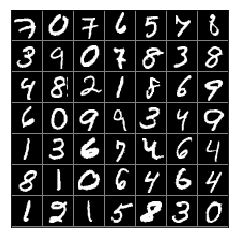

In [6]:
display_images(mnist.train.images[:49], shape=(28,28))

In [28]:
def weights(shape):
    initial = tf.random_normal(shape, stddev=1/np.sqrt(shape[0]))
    return tf.Variable(initial, dtype=tf.float32)

def biases(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, dtype=tf.float32)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool(x, l1=2, l2=2):
    return tf.nn.max_pool(x, ksize=[1, l1, l2, 1],
                          strides=[1,2,2,1], padding='SAME')

def build_convnet(input_size=784, nlabels=10, patch_sizes=[5,5], conv_channels=[32,64], n_fc=1024,
                 optimizer=tf.train.AdamOptimizer(1e-4)):
    nlayers = len(patch_sizes)
    assert nlayers == len(conv_channels)
    input_length = int(np.sqrt(input_size))
    assert input_length**2 == 784
    d = {} # dictionary to hold graph objects
    
    d['graph'] = tf.Graph()
    d['x'] = tf.placeholder(tf.float32, shape=[None, input_size], name='input')
    d['x_im'] = tf.reshape(d['x'], [-1, input_length, input_length, 1])
    d['y_true'] = tf.placeholder(tf.float32, shape=[None, nlabels])
    
    # construct hidden layers
    d['weights'] = []
    d['biases'] = []
    d['convs'] = []
    d['pools'] = [d['x_im']]
    for ii in range(nlayers):
        Wshape = [patch_sizes[ii]]*2
        Wshape += [1] if ii == 0 else [conv_channels[ii-1]]
        Wshape += [conv_channels[ii]]
        d['weights'].append(weights(Wshape))
        d['biases'].append(biases([conv_channels[ii]]))
        d['convs'].append(tf.nn.relu(conv2d(d['pools'][ii], d['weights'][ii]) + d['biases'][ii],
                                     name='conv'+str(ii)))
        d['pools'].append(max_pool(d['convs'][ii]))
        
    # fully connected layer
    final_pool_size = 7*7*conv_channels[-1]
    d['fcweights'] = weights([final_pool_size, n_fc])
    d['fcbiases'] = biases([n_fc])
    d['final_pool_flat'] = tf.reshape(d['pools'][-1], [-1, final_pool_size])
    d['fc_acts'] = tf.nn.relu(tf.matmul(d['final_pool_flat'], d['fcweights']) + d['fcbiases'])
    d['keep_prob'] = tf.placeholder(tf.float32)
    d['fc_acts_drop'] = tf.nn.dropout(d['fc_acts'], d['keep_prob'])
    
    # readout layer
    d['ro_weights'] = weights([n_fc, nlabels])
    d['ro_biases'] = biases([nlabels])
    d['y_est'] = tf.matmul(d['fc_acts_drop'], d['ro_weights']) + d['ro_biases']
    
    # loss and learning
    d['crossent'] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=d['y_true'], logits=d['y_est']))
    d['train_step'] = optimizer.minimize(d['crossent'])
    var_list = d['weights'] + d['biases'] + [d['fcweights'], d['fcbiases'], d['ro_weights'], d['ro_biases']]
    d['gradient'] = optimizer.compute_gradients(d['crossent'], var_list=var_list)
    d['correct'] = tf.equal(tf.argmax(d['y_est'],1), tf.argmax(d['y_true'],1))
    d['accuracy'] = tf.reduce_mean(tf.cast(d['correct'], tf.float32))
    
    return d

In [39]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5,
                            allow_growth=True)
BATCH_SIZE= 50
config = tf.ConfigProto(gpu_options=gpu_options)
def train(graph_dict, data, nbatch, saver, keep_prob=0.5, savefile=None, load=False):
    d = graph_dict
    acc = []
    gnorm = []
    with tf.Session(config=config) as sess:
        if load:
            saver.restore(sess, savefile or 'tmp/convMNIST.ckpt')
        else:
            sess.run(tf.global_variables_initializer())
        for tt in range(nbatch):
            batch = data.train.next_batch(BATCH_SIZE)
            if tt % 100 == 0:
                train_accuracy = sess.run(d['accuracy'], feed_dict={
                        d['x']: batch[0], d['y_true']: batch[1], d['keep_prob']: 1.0})
                acc.append(train_accuracy)
                print('step %d, training accuracy %g' % (tt, train_accuracy))
            _, grad = sess.run([d['train_step'], d['gradient']], feed_dict={
                                d['x']: batch[0], d['y_true']: batch[1], d['keep_prob']: 0.5})
            gradnorms = [np.linalg.norm(g[0]) for g in grad]
            gnorm.append(gradnorms)
        test_accuracy = sess.run(d['accuracy'], feed_dict={
                                 d['x']: data.test.images, d['y_true']: data.test.labels, d['keep_prob']: 1.0})
        saver.save(sess, savefile or 'tmp/convMNIST.ckpt')
    return acc, gnorm, test_accuracy

In [40]:
gd = build_convnet(optimizer = tf.train.GradientDescentOptimizer(1e-4))
saver=tf.train.Saver()
accuracy, gnorm, test_accuracy = train(gd, mnist, 20000, saver, keep_prob=1.0, savefile='tmp/nodropout_sgd.ckpt')

step 0, training accuracy 0.1
step 100, training accuracy 0.68
step 200, training accuracy 0.78
step 300, training accuracy 0.9
step 400, training accuracy 0.88
step 500, training accuracy 0.92
step 600, training accuracy 0.82
step 700, training accuracy 0.9
step 800, training accuracy 0.92
step 900, training accuracy 0.88
step 1000, training accuracy 0.88
step 1100, training accuracy 0.96
step 1200, training accuracy 0.88
step 1300, training accuracy 0.96
step 1400, training accuracy 0.9
step 1500, training accuracy 0.9
step 1600, training accuracy 0.96
step 1700, training accuracy 0.92
step 1800, training accuracy 0.9
step 1900, training accuracy 0.88
step 2000, training accuracy 0.92
step 2100, training accuracy 0.94
step 2200, training accuracy 0.94
step 2300, training accuracy 0.9
step 2400, training accuracy 0.94
step 2500, training accuracy 0.94
step 2600, training accuracy 0.96
step 2700, training accuracy 0.92
step 2800, training accuracy 0.96
step 2900, training accuracy 0.86

In [60]:
norms = [[his[ii] for his in gnorm] for ii in range(len(gnorm[0]))]
norms = np.array(norms)
norms = norms[:,::100]

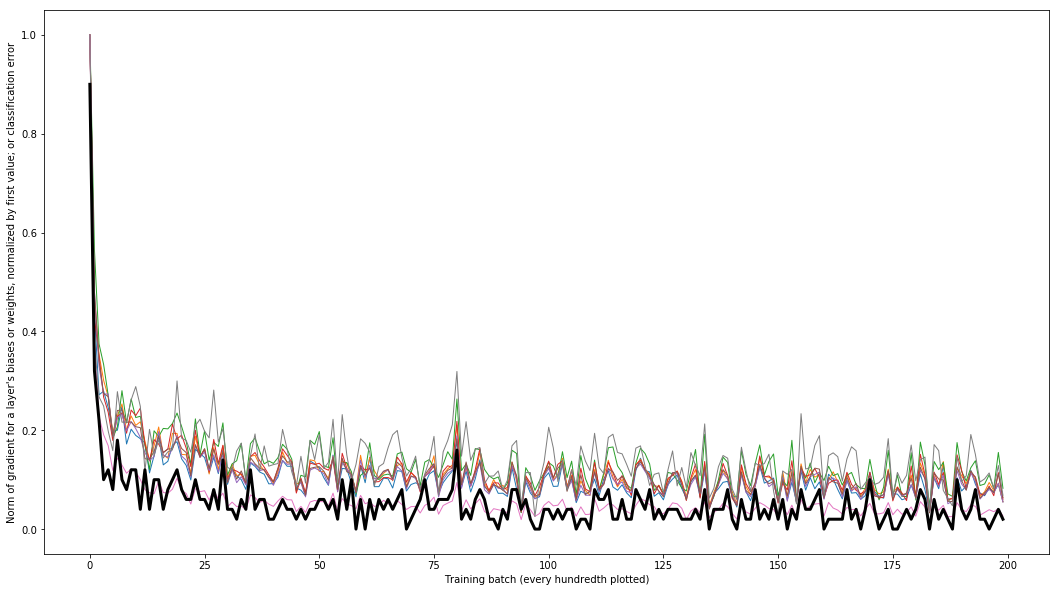

In [67]:
plt.figure(figsize=(18,10))
plt.plot((norms/norms[:,0][:,None]).T, linewidth=1)
plt.ylabel('Norm of gradient for a layer\'s biases or weights, normalized by first value; or classification error')
plt.xlabel('Training batch (every hundredth plotted)')
plt.plot([1-a for a in accuracy], linewidth=3, color='k')

In [63]:
print(test_accuracy)

0.968
